## Github Repository Process Metrics Extraction and Matching with Product Metrics Dataset

Data Sources: 
- [Bavota et al. (2016)](https://figshare.com/articles/An_Experimental_Investigation_on_the_Innate_Relationship_between_Quality_and_Refactoring/1207916)
- [Apache Ant Mirror Repository](https://github.com/apache/ant)

Paper References: 
- Tanaka D., Choi E., Yoshida N., Fujiwara K., Port D., Iida H. (20xx). An Investigation of the Relationship Between Extract Method and Process Metrics. The Institute of Electronics, Information and Communication Engineers.
- Kumar, L., & Sureka, A. (2017). Application of LSSVM and SMOTE on Seven Open Source Projects for Predicting Refactoring at Class Level. Asia-Pacific Software Engineering Conference (APSEC 2017), 90–99. https://doi.org/10.1109/APSEC.2017.15
- Bavota, G., De Lucia, A., Di Penta, M., Oliveto, R., & Palomba, F. (2015). An experimental investigation on the innate relationship between quality and refactoring. Journal of Systems and Software, 107, 1–14. https://doi.org/10.1016/j.jss.2015.05.024
- Lee, T., Nam, J., Han, D., Kim, S., & In, H. P. (2011). Micro Interaction Metrics for Defect Prediction. Proceedings of the 19th ACM SIGSOFT Symposium and the 13th European Conference on Foundations of Software Engineering, 5589(c), 311–321. https://doi.org/10.1145/2025113.2025156


In [1]:
import os
import pandas as pd
import subprocess

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Data directories

data_dir = "data/raw/badsmells/data/"
projects = ["apache-ant", "xerces2-j"]

ddata_dir = "data/transformed/"

In [4]:
# Loading dataset and dropping duplicates
prod_df = pd.DataFrame()
for p in projects:
    p_dir = data_dir + p + "/" + p + "/"
    for f in os.listdir(p_dir):
        if f.endswith("metrics.csv"):
            df = pd.read_csv(p_dir + f, sep=";", index_col=False)
            df["proj"] = p
            prod_df = prod_df.append(df)
prod_df.drop_duplicates(inplace=True)

In [5]:
# Standardization of version names
dversions = []
for ver in prod_df["Version"]:
    dver = ""
    
    for i in ver.split("."):
        if len(i) == 2 and i[0] == "0":
            dver = dver + i[1] + "."
            continue
        dver = dver + i + "."
    dversions.append(dver.rstrip("."))
prod_df["Version"] = dversions
prod_df["Version"] = prod_df["Version"].replace(to_replace="1.8.0final", value="1.8.0")
prod_df["Version"].value_counts()

print("Available versions: {}".format(prod_df["Version"].unique()))
print("nVersions: {}".format(len(prod_df["Version"].unique())))

Available versions: ['1.1' '1.2' '1.3' '1.4' '1.4.1' '1.5' '1.5.1' '1.5.4' '1.6.0' '1.6.1'
 '1.6.2' '1.6.3' '1.6.4' '1.7.0' '1.7.1' '1.8.0' '1.8.1' '1.8.2' '1.0.0'
 '1.0.4' '1.2.0' '1.2.1' '1.2.2' '1.2.3' '1.3.0' '1.3.1' '1.4.0' '1.4.2'
 '1.4.3' '1.4.4' '2.0.0' '2.0.0alpha' '2.0.0beta' '2.0.0beta2' '2.0.0beta3'
 '2.0.0beta4' '2.0.1' '2.0.2' '2.1.0' '2.2.0' '2.2.1' '2.3.0' '2.4.0'
 '2.5.0' '2.6.0' '2.6.1' '2.6.2' '2.7.0' '2.7.1' '2.8.0' '2.8.1' '2.9.0']
nVersions: 52


In [6]:
xer_sel_versions = ['2.0.1', '2.0.2', '2.1.0', '2.2.0', '2.2.1', '2.3.0', '2.4.0', '2.5.0', '2.6.0', '2.6.1', '2.6.2', '2.7.0', '2.7.1']
ant_sel_versions = ['1.5', '1.5.1', '1.5.4', '1.6.0', '1.6.1', '1.6.2', '1.6.3', '1.6.4', '1.7.0', '1.7.1', '1.8.0', '1.8.1', '1.8.2']

### Process Metrics Extraction
Will only consider versions 1.5 onwards for stability. Revision split points
- 1:5
- 2:4
- 3:3
- 4:2
- 5:1

In [105]:
%%time
proc_proj_df = pd.DataFrame()

for proj in projects:
    os.chdir("ghrepos/{}/".format(proj))
    
    proj_df = prod_df[prod_df["proj"] == proj]
    
    if proj == "xerces2-j":
        sel_versions = xer_sel_versions
        ver_prepend = "Xerces-J_"
        start_w = ("dom", "dom3", "javax", "jaxp", "sax", "socket", "simplety", "ui", "util", "xni", "xs")
        
    else:
        sel_versions = ant_sel_versions
        ver_prepend = "rel/"
        starts_w = ("main", "org")
        
    split_points = range(0, len(sel_versions), 2)
    proc_period = []
    ref_period = []
    for i in range(1, 6):
        proc_period.append(sel_versions[:split_points[i]+1])
        ref_period.append(sel_versions[split_points[i]+1:])

    info_cols = ['Refactoring', 'Version', 'Class']
    for split in range(len(proc_period)):
        print("===== SPLIT {} =====".format(split))
        # Get the start and end of process metrics period versions
        start_proc, end_proc = proc_period[split][0], proc_period[split][-1]
        if proj == "xerces2-j":
            start_proc, end_proc = start_proc.replace(".", "_"), end_proc.replace(".", "_")
        start_comm = subprocess.check_output('git rev-list -n 1 {}{}'.format(ver_prepend, start_proc), shell=True)[:8].decode("utf-8")
        end_comm = subprocess.check_output('git rev-list -n 1 {}{}'.format(ver_prepend, end_proc), shell=True)[:8].decode("utf-8")

        # Get the rows with version inside the ref period
        met_df = proj_df[proj_df["Version"].isin(proc_period[split])][info_cols]
        ref_df = proj_df[proj_df["Version"].isin(ref_period[split])]

        # For NC (Number of changes)
        print("==> Processing NC..")
        output = subprocess.check_output("git diff --name-only {}{} {}{}".format(ver_prepend, start_proc, ver_prepend, end_proc), shell=True)
        
        diff_classes_raw = [i for i in str(output).split("\\n") if i.endswith(".java") and i.lstrip("src/").startswith(start_w)]
        diff_classes = [i.lstrip("src/").rstrip(".java").replace("/",".") for i in diff_classes_raw]
        
        diff_classes = set(diff_classes) & set(met_df["Class"].values)
        met_df["NC"] = met_df["Class"].apply(lambda x: 1 if x in diff_classes else 0)

        # For NDC (Number of Distinct Committers)
        # For AG (Age of revision)
        print("==========================")
        print("==> Processing AG and NDC..")
        ag = []
        ndc = []
        for i in met_df["Class"].values:
            class_str_name = "src/"+i.replace(".","/")+".java"
            rth_commit = subprocess.check_output("git log {} --format=%ct {} | head -n1".format(end_comm, class_str_name), shell=True)
            first_commit = subprocess.check_output("git log --format=%ct {} | tail -1".format(class_str_name), shell=True)
            
            if first_commit == b'' or rth_commit == b'':
                ag.append(None)
            else:
                dt = int(rth_commit) - int(first_commit)
                ag.append(dt)

            authors = subprocess.check_output("git shortlog -s {}{}...{}{} -- {}".format(ver_prepend, start_proc, ver_prepend, end_proc, class_str_name), shell=True)
            if authors == "b''":
                ndc.append(0)
            else:
                n_authors = len([i.strip().split("\t") for i in authors.decode("utf-8").strip("\n").split("\n") if len(i)>0])
                ndc.append(n_authors)
        met_df["AG"] = ag
        met_df["NDC"] = ndc

        # For ADD and DEL
        print("==> Processing ADD&DEL..")
        output = subprocess.check_output("git diff --numstat {} {} | grep -E '*.java'".format(start_comm, end_comm), shell=True)
        add_del_df = pd.DataFrame([entry.split("\\t") for entry in str(output).lstrip("b'").split("\\n")], columns=["ADD", "DEL", "Class"])
        add_del_df.dropna(axis=0, subset=["Class"], inplace=True)

        add_del_df = add_del_df[(add_del_df["Class"].str.startswith(tuple(["src/" + i for i in starts_w])))]
        add_del_df["Class"] = add_del_df["Class"].apply(lambda x: x.lstrip("src/").rstrip(".java").replace("/", "."))
        met_df = pd.merge(met_df, add_del_df, how="left", on="Class")

        # For CHURN
        print("==> Processing CHURN..")
        met_df["CHURN"] = met_df["ADD"] + met_df["DEL"]

        met_df["nsplit"] = split+1

        new_df = pd.merge(met_df, ref_df, on=['Class', 'Refactoring'])
        proc_proj_df = proc_proj_df.append(new_df)

    os.chdir("../../")

===== SPLIT 0 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 1 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 2 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 3 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 4 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 0 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 1 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 2 =====
==> Processing NC..
==> Processing AG and NDC..
==> Processing ADD&DEL..
==> Processing CHURN..
===== SPLIT 3 =====
==> Processing NC..
==> Processing AG and NDC..
==> 

In [104]:
os.chdir("../../")

In [108]:
proc_proj_df.to_csv(ddata_dir+"proc_prod.csv", index=False)

In [ ]:
info_cols = ['Version_x',  'Version_y', 'Class', 'nsplit']
label_cols = ['Refactoring', 'w_ref']
proc_cols = ['NC', 'AG', 'NDC', 'ADD', 'DEL', 'CHURN']
prod_cols = ['LOC', 'WMC', 'DIT', 'NOC', 'RFC','CBO', 'LCOM', 'NOM', 'NOA', 'NOO', 'CCBC', 'C3']

NameError: name 'proc_prod_df' is not defined

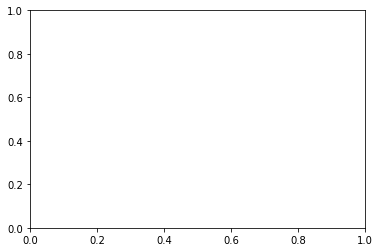

In [109]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(proc_prod_df[prod_cols].corr(), interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+prod_cols)
ax.set_yticklabels(['']+prod_cols)

plt.show()